## Modelling the Baltic Sea using grid-based methods

In [1]:
from pygradu import gridify
import shapely.geometry
import pandas as pd
import numpy as np
import importlib

grid = gridify.area_to_grid(side_length=5000)

Original NE: POINT (134 40)
Original SW: POINT (123 32)
Transformed NE: (798015.8738997555, 745576.6479352411)
Transformed SW: (-178108.15703831997, -158644.45983641956)
col_count 195
row_count 180
grid_size 35100


In [2]:
grid.extract_coords_lat_lon(2)

[32.02661292484385, 123.13169521354813]

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 
from mpl_toolkits.basemap import Basemap

def visualize_graph(graph, grid):
    nodes = graph.original.drop_duplicates().values
    
    lats = []
    lons = []
    
    
    for node in nodes:
        latlon = grid.extract_coords_lat_lon(node)
        lats.append(latlon[0])
        lons.append(latlon[1])


    nodes = graph.connected.drop_duplicates().values
    lats2 = []
    lons2 = []
    for node in nodes:
        latlon = grid.extract_coords_lat_lon(node)
        lats2.append(latlon[0])
        lons2.append(latlon[1])

    f = plt.figure(figsize=[25,25])
    
    print(min(lats))
    print(min(lons))
    
    m = Basemap(llcrnrlon = min(lons),llcrnrlat = min(lats), urcrnrlon = max(lons),
               urcrnrlat = max(lats),
               resolution='l')
    m.shadedrelief()

    plt.plot(lons2, lats2, 'o', c='red', alpha=1, markersize=4)
    plt.plot(lons, lats, 'o', c='orange', alpha=1, markersize=4)

    plt.show()
    
def visualize_graph_connections(graph, grid):
    rows = graph.drop_duplicates().values
    lats = []
    lons = []

    m = Basemap(llcrnrlon = min(lons),llcrnrlat = min(lats), urcrnrlon = max(lons),
               urcrnrlat = max(lats),
               resolution='l')
    m.shadedrelief()
    
    f = plt.figure(figsize=[25,25])
    for row in rows:
        original_latlon = grid.extract_coords_lat_lon(row[0])
        connected_latlon = grid.extract_coords_lat_lon(row[1])
        lats = [original_latlon[0], connected_latlon[0]]
        lons = [original_latlon[1], connected_latlon[1]]

        plt.plot(lons, lats, alpha=1, markersize=2, linewidth=1, c='black')


    plt.show()

#### Create a sea graph with adjacent model

In [4]:
import pandas as pd


%time sea_graph = gridify.create_area_graph(grid, adjacent=True)
graph_cols = ['original', 'connected']
sea_graph = pd.DataFrame(sea_graph, columns=graph_cols)
sea_graph.head(5)

CPU times: user 328 ms, sys: 16.2 ms, total: 344 ms
Wall time: 342 ms


original  connected
0         0          1
1         0        180
2         0        181
3         1          0
4         1          2

In [5]:
sea_graph['connected'][100]

199

31.964037193539944
122.59250216996253


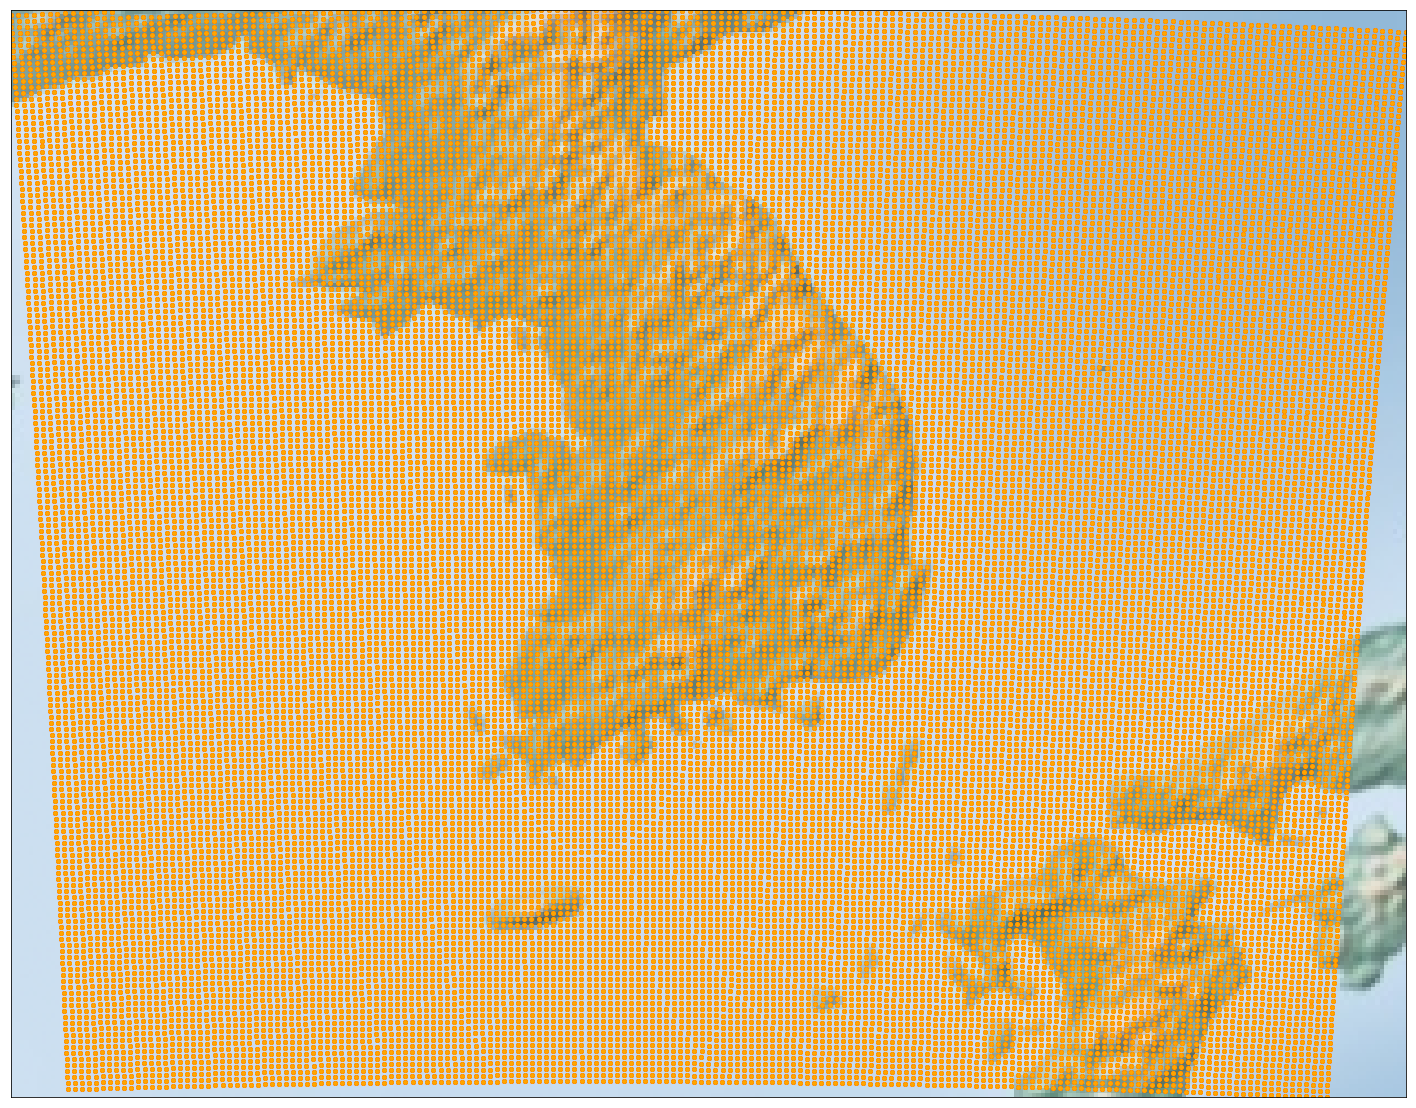

In [6]:
visualize_graph(sea_graph, grid)

In [7]:
import fiona
import pyproj
from shapely.geometry import shape
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
from shapely.geometry import Point

def get_nodes_inside_area(graph, area):
    keep = []
    for node in graph.original.drop_duplicates().values:
        latlon = grid.extract_coords_lat_lon(node)
        p = Point((latlon[1], latlon[0]))
        if area.contains(p):
            keep.append(node)
    return set(keep)

from tqdm import tqdm

def get_nodes_not_inside_area_accurate(graph, area):
    keep = []
    for node in tqdm(graph.original.drop_duplicates().values):
        rowcol = grid.extract_coords(node)
        row = rowcol[0]
        col = rowcol[1]
        sw = shapely.geometry.Point(pyproj.transform(grid.p_to, grid.p_from, grid.cols[col], grid.rows[row]))
        se = shapely.geometry.Point(pyproj.transform(grid.p_to, grid.p_from, grid.cols[col] + grid.side_length, grid.rows[row]))
        nw = shapely.geometry.Point(pyproj.transform(grid.p_to, grid.p_from, grid.cols[col], grid.rows[row] + grid.side_length))
        ne = shapely.geometry.Point(pyproj.transform(grid.p_to, grid.p_from, grid.cols[col] + grid.side_length, grid.rows[row] + grid.side_length))
        pointlist = list([sw, se, ne, nw])

        cell = shapely.geometry.Polygon([[p.x, p.y] for p in pointlist])

        if  area.contains(cell):
            continue
        
        keep.append(node)
            
    return set(keep)

False
CPU times: user 605 µs, sys: 0 ns, total: 605 µs
Wall time: 614 µs
False
CPU times: user 202 µs, sys: 0 ns, total: 202 µs
Wall time: 176 µs


100%|██████████| 32234/32234 [34:02<00:00, 15.78it/s]


CPU times: user 34min 5s, sys: 5.7 s, total: 34min 11s
Wall time: 34min 2s
31.964037193539944
122.60128560014387


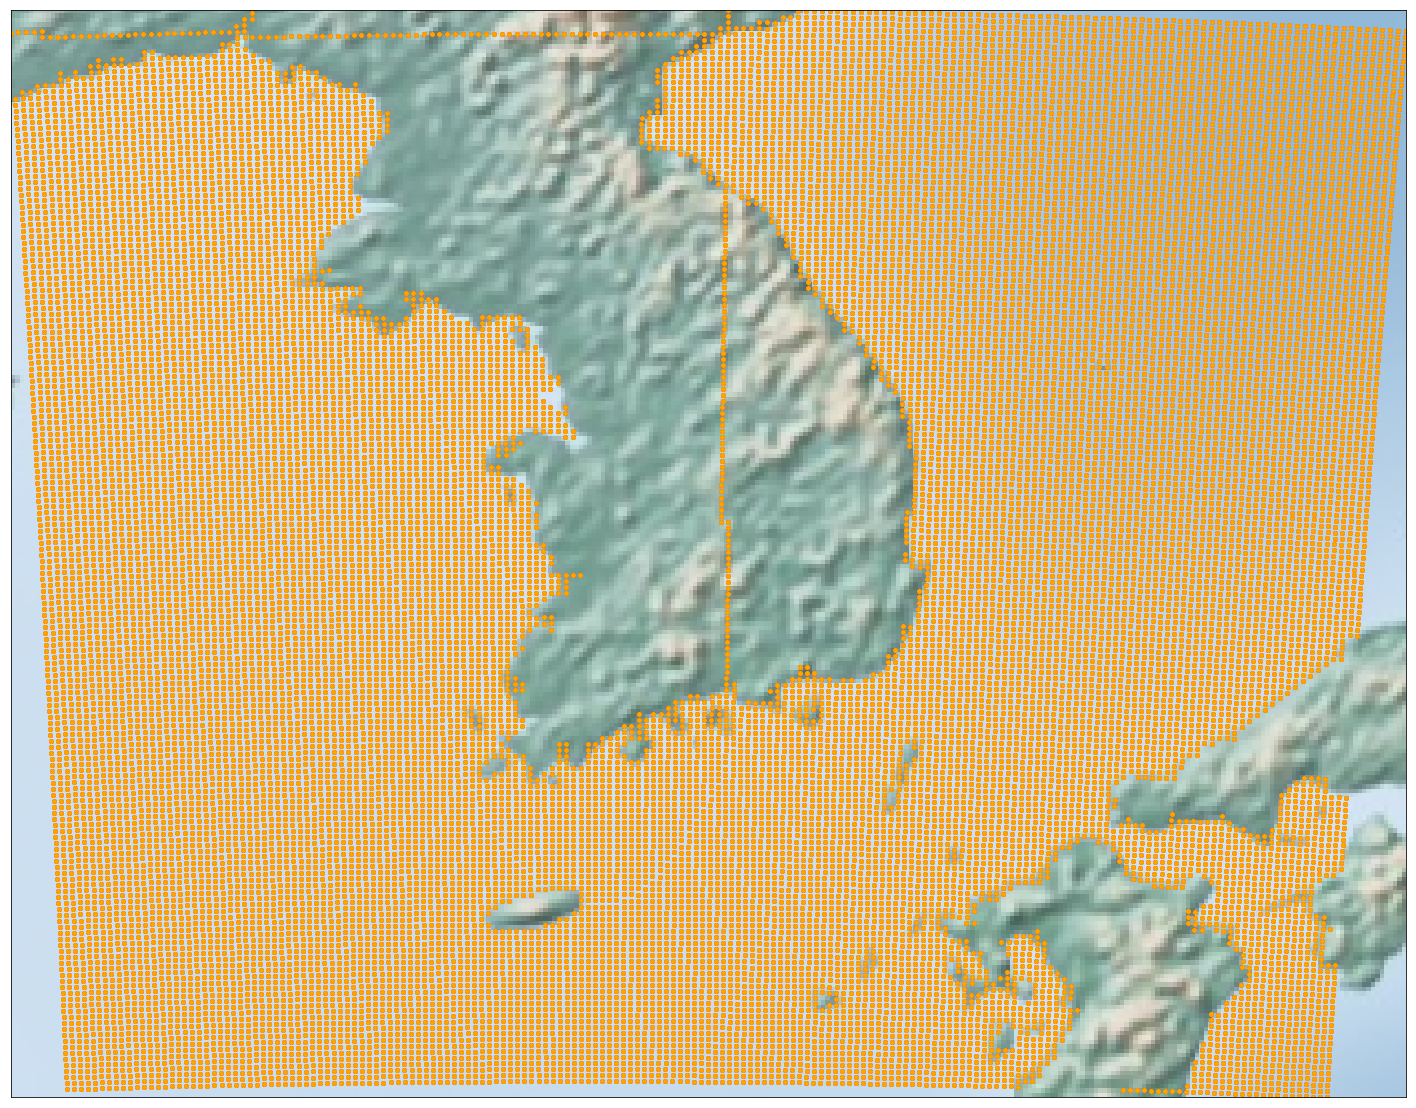

In [8]:
land = MultiPolygon([shape(pol['geometry']) for pol in fiona.open('data/shapes/4326_land.shp')])

%time print(land.contains(Point(30, 53)))
%time print(land.contains(Point(14.584798172002538,53.92132432670449)))

%time keep = get_nodes_not_inside_area_accurate(sea_graph, land)

sea_graph = sea_graph[sea_graph.original.isin(keep)]

originals = set(sea_graph.original.drop_duplicates().values)

sea_graph = sea_graph[sea_graph.connected.isin(originals)]

visualize_graph(sea_graph, grid)

#### You can also create the sea graph with only one command by providing the land (=filtered geom) to gridify.create_sea_graph function

In [9]:
land = MultiPolygon([shape(pol['geometry']) for pol in fiona.open('data/shapes/4326_land.shp')])
%time print(land.contains(Point(30, 53)))
%time print(land.contains(Point(20.8464268,60.8670341)))

%time sea_graph = gridify.create_sea_graph(grid, adjacent=True, exclude_geom=land)

graph_cols = ['original', 'connected']
base_graph = pd.DataFrame(sea_graph, columns=graph_cols)
base_graph.head(5)

False
CPU times: user 637 µs, sys: 0 ns, total: 637 µs
Wall time: 648 µs
False
CPU times: user 280 µs, sys: 0 ns, total: 280 µs
Wall time: 242 µs
CPU times: user 34min 43s, sys: 10.6 ms, total: 34min 43s
Wall time: 34min 43s


original  connected
0         0          1
1         0        180
2         0        181
3         1          0
4         1          2

31.964037193539944
122.59250216996253


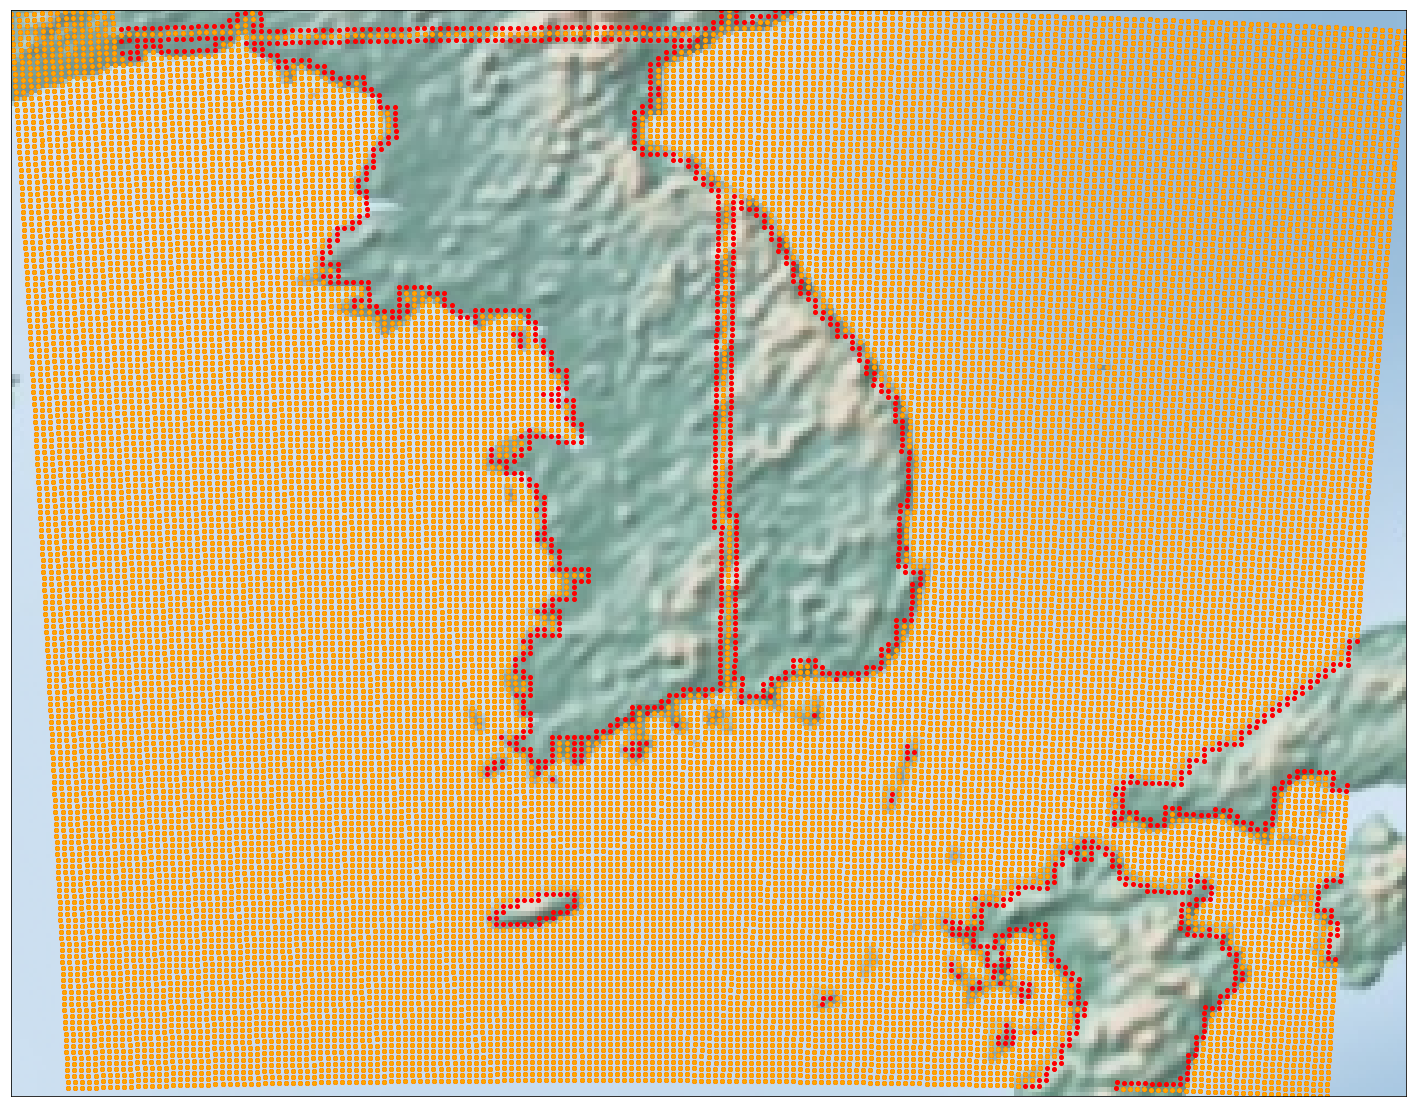

In [10]:
visualize_graph(base_graph, grid)

#### Remove impossible connections

31.964037193539944
122.59250216996253


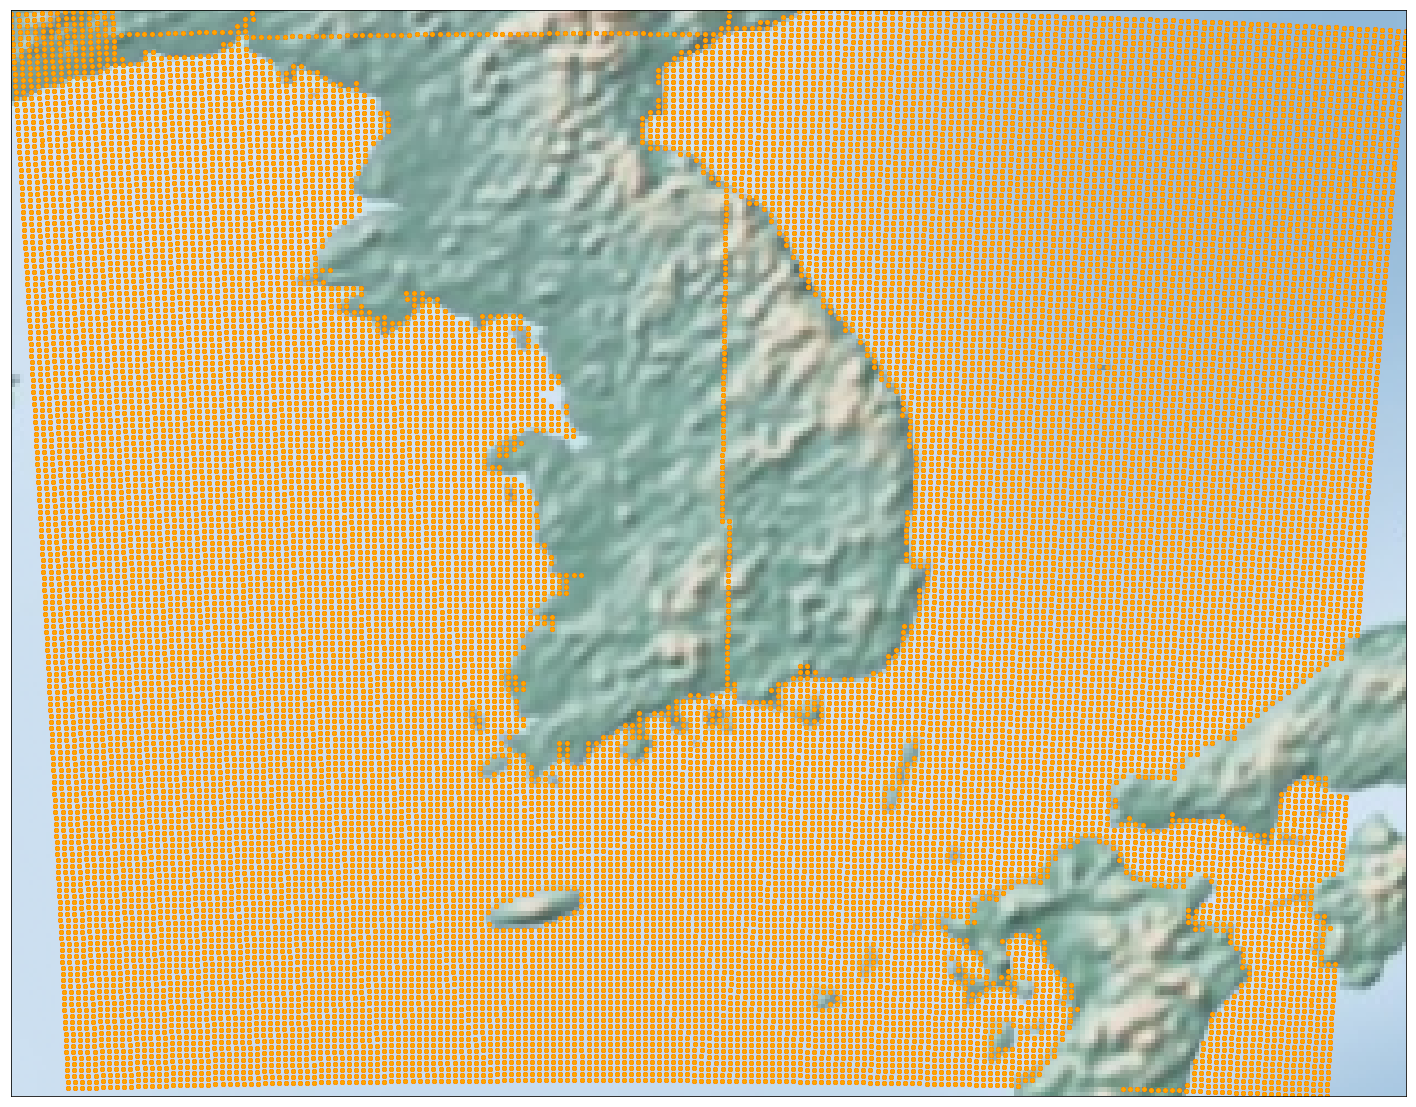

In [11]:
originals = set(base_graph.original.drop_duplicates().values)
base_graph = base_graph[base_graph.connected.isin(originals)]
visualize_graph(base_graph, grid)

31.964037193539944
122.59250216996253


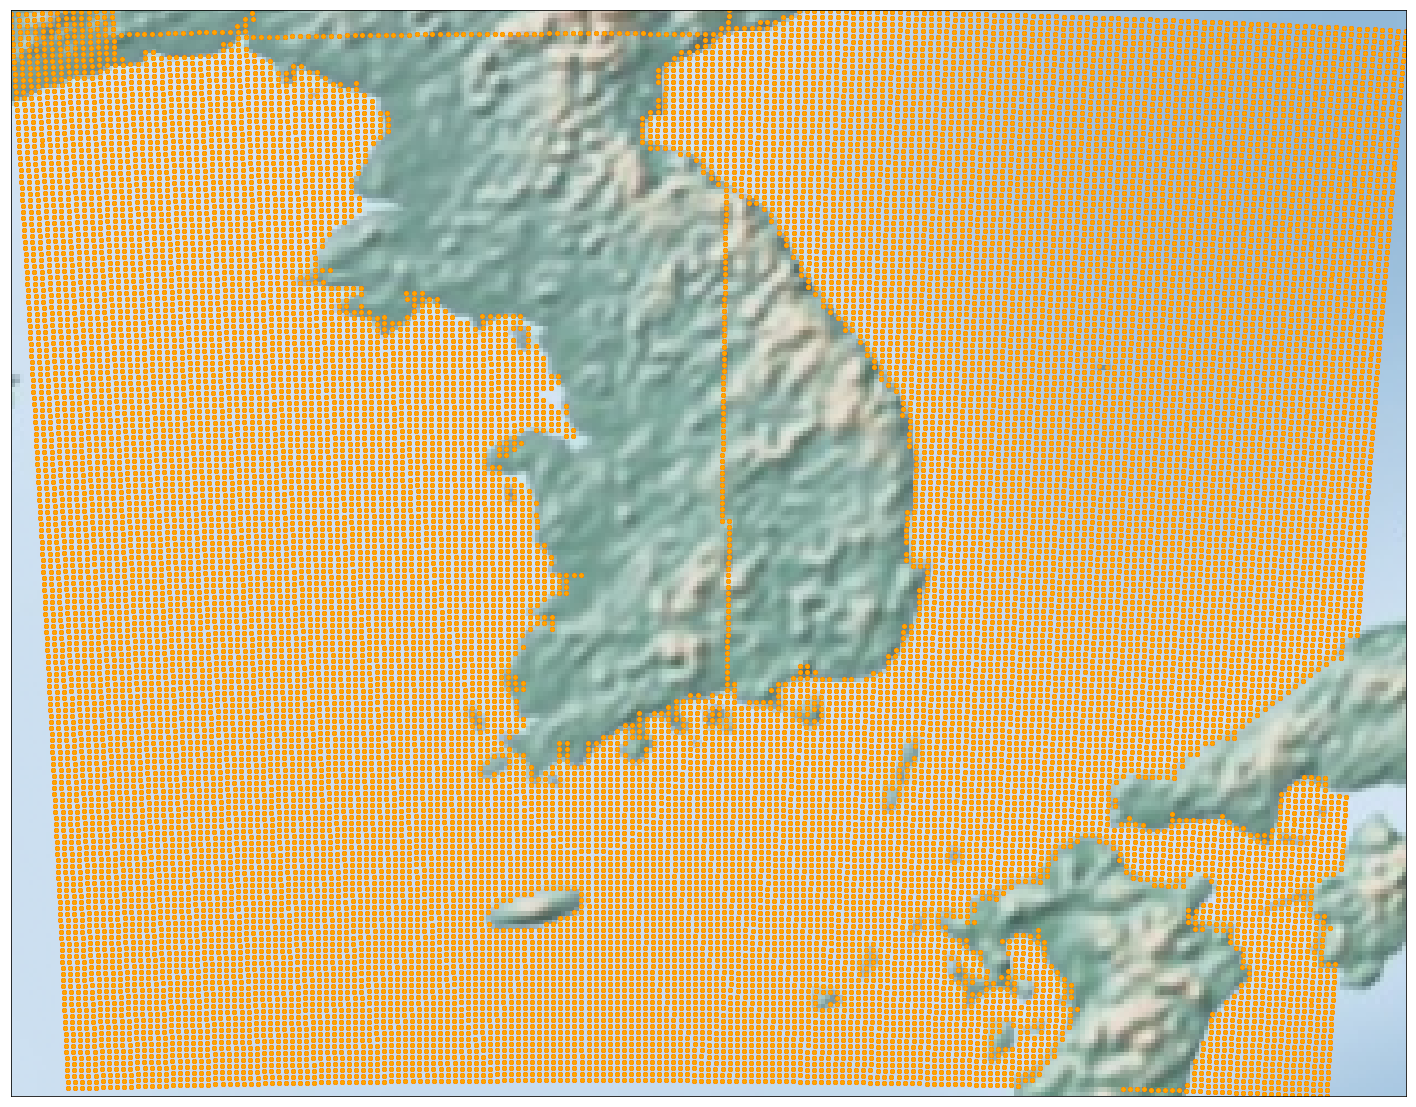

In [12]:
visualize_graph(base_graph, grid)

#### Removing nodes on land

False
CPU times: user 559 µs, sys: 2 µs, total: 561 µs
Wall time: 304 µs
False
CPU times: user 1.11 ms, sys: 0 ns, total: 1.11 ms
Wall time: 921 µs
31.964037193539944
122.59250216996253


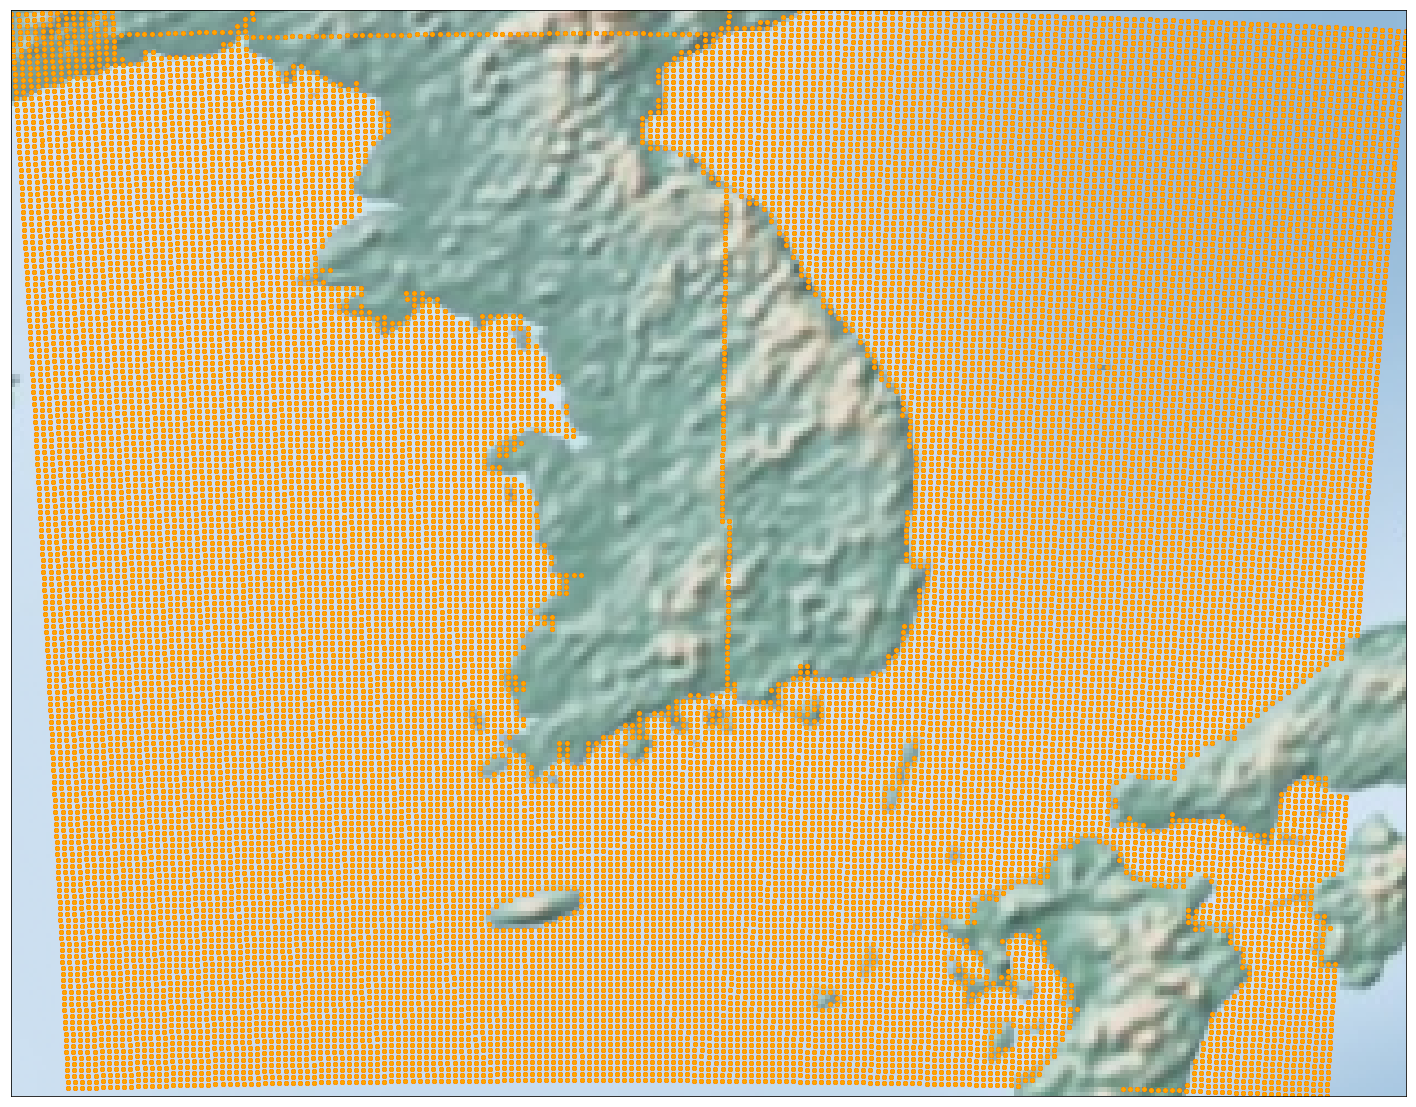

In [15]:
import json
with open('data/shapes/4326_sea.geojson') as f:
    data = json.load(f)

#print(data)
    
sea = shape(data['features'][1]['geometry'])

#print(sea)
%time print(sea.contains(Point(30, 53)))
%time print(sea.contains(Point(14.584798172002538,53.92132432670449)))

keep = []
for node in base_graph.original.drop_duplicates().values:
    latlon = grid.extract_coords_lat_lon(node)
    p = Point((latlon[1], latlon[0]))
    if sea.contains(p):
        keep.append(node)
keep = set(keep)
base_graph2 = base_graph[base_graph.original.isin(keep)]

originals = set(base_graph.original.drop_duplicates().values)
base_graph2 = base_graph[base_graph.connected.isin(originals)]

visualize_graph(base_graph2, grid)

#### Visualize a neighbors of a single node

In [16]:
counts = base_graph2.groupby(['original']).size()
counts = counts.to_frame().reset_index()
counts.columns = ['original', 'neighbors']
counts.neighbors.max()
counts[counts.neighbors == 8].tail(10)

original  neighbors
24929     32043          8
24930     32044          8
24931     32045          8
24932     32046          8
24933     32047          8
24934     32048          8
24935     32049          8
24936     32050          8
24937     32051          8
24938     32052          8

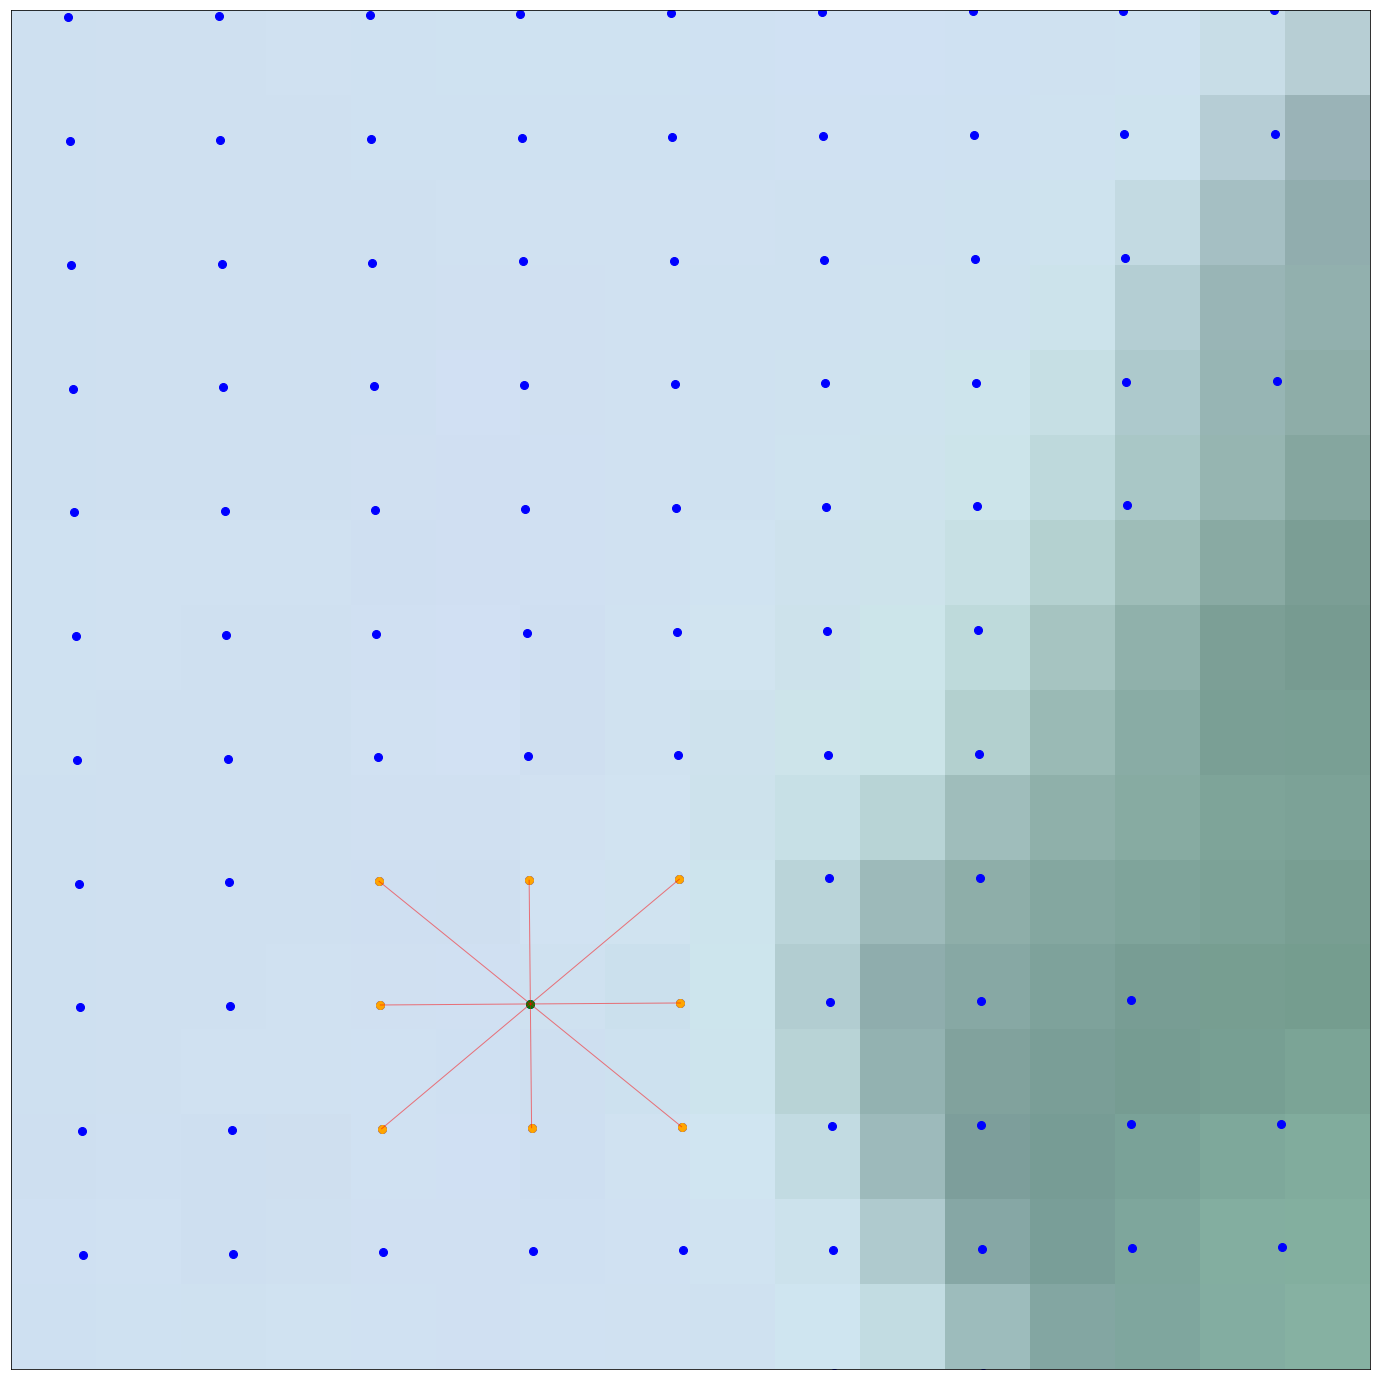

In [36]:
nodes = base_graph2.original.drop_duplicates().values
lats = []
lons = []
for node in nodes:
    latlon = grid.extract_coords_lat_lon(node)
    lats.append(latlon[0])
    lons.append(latlon[1])

f = plt.figure(figsize=[25,25])


m = Basemap(llcrnrlon = 126,llcrnrlat = 35, urcrnrlon = 126.5,
               urcrnrlat =35.5,
               resolution='l')


m.shadedrelief()



plt.plot(lons, lats, 'o', c='blue', alpha=1, markersize=8)

start_node = 12120
nodes = base_graph2[base_graph2.original == start_node].connected.values

start_latlon = grid.extract_coords_lat_lon(start_node)
plt.plot(start_latlon[1], start_latlon[0], 'o', c='green', alpha=1, markersize=8)
for node in nodes:
    lats = []
    lons = []
    lats.append(start_latlon[0])
    lons.append(start_latlon[1])
    
    latlon = grid.extract_coords_lat_lon(node)
    lats.append(latlon[0])
    lons.append(latlon[1])
    
    plt.plot(lons[1], lats[1], 'o', c='orange', alpha=1, markersize=8)
    plt.plot(lons, lats, c='red', alpha=0.5, markersize=10, linewidth=1)

plt.show()

In [37]:
base_graph.to_csv("data/models/sea_5km_model.csv")